<a href="https://colab.research.google.com/github/project-ida/two-state-quantum-systems/blob/master/09-destructive-interference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <a href="https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/09-destructive-interference.ipynb" target="_parent"><img src="https://nbviewer.jupyter.org/static/img/nav_logo.svg" alt="Open In nbviewer" width="100"/></a>

# 9 - Destructive interference

In the last tutorial we observed speed-ups in emission and excitation transfer rates as a result of the delocalisation of excitations across many TLS. We understood these rate accelerations to be a result of the constructive interference of many quantum pathways.

In this tutorial, we'll look at the other side of the coin - destructive interference. We'll see where it comes from, how it manifests in our quantum system and discuss what options are available for controlling/removing it.

In [ ]:
# RUN THIS IF YOU ARE USING GOOGLE COLAB
import sys
import os
!pip install qutip==4.7.6
!git clone https://github.com/project-ida/two-state-quantum-systems.git
sys.path.insert(0,'/content/two-state-quantum-systems')
os.chdir('/content/two-state-quantum-systems')

In [1]:
# Libraries and helper functions

%matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import Image
from IPython.display import Video

import numpy as np
from itertools import product
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

from qutip import *
from qutip.piqs import *
from qutip.cy.piqs import j_min, j_vals, m_vals

# The helper file below brings functions created in previous tutorials
from libs.helper_09_tutorial import *

## 9.1 - Recap
Last time, we described delocalised excitations transferring from one "place" to another by breaking up the overall system into 2 parts - system A and system B. Each system can in principle have its own number of TLS ($N_A$, $N_B$) and its own number of excitations ($n_{+A}$, $n_{+B}$). 

The Hamiltonian for this AB situation is given by:

$$H =  \Delta E_A J_{N_Az}^{(A)} + \Delta E_B J_{N_Bz}^{(B)} + \hbar\omega\left(a^{\dagger}a +\frac{1}{2}\right) + U_A\left( a^{\dagger} + a \right)2J_{N_Ax}^{(A)} + U_B\left( a^{\dagger} + a \right)2J_{N_Bx}^{(B)}$$

where:

- The [total angular momentum operators](https://www2.ph.ed.ac.uk/~ldeldebb/docs/QM/lect15.pdf) ($J$) for $N$ TLS:

$$J_{Nx} = \overset{N}{\underset{n=1}{\Sigma}} S_{n x} \,\,\,\,\,\, J_{Ny} = \overset{N}{\underset{n=1}{\Sigma}} S_{n y} \,\,\,\,\,\, J_{Nz} = \overset{N}{\underset{n=1}{\Sigma}} S_{n z}$$

- The spin operators ($S$) for a [spin 1/2 particle](https://en.wikipedia.org/wiki/Spin-%C2%BD#Observables):

$$
S_x = \frac{1}{2}\sigma_x \,\,\,\,\,\, S_y = \frac{1}{2}\sigma_y \,\,\,\,\,\, S_z = \frac{1}{2}\sigma_z
$$

In [2]:
H_latex_AB = "$H = \Delta E (J_{Nz}^{(A)}+J_{Nz}^{(B)}) + \hbar\omega(a^{{\dagger}}a +1/2) + U( a^{{\dagger}} + a )2(J_{Nx}^{(A)} + J_{Nx}^{(B)})$ "

We previously focused on the case where:
- System A and B have the same transition energy: $ \Delta E_A =  \Delta E_B =  \Delta E$
- System A and B couple to the boson field in the same way: $U_A = U_B = U$
- System A and B consist of the same number ot TLS: $N_A = N_B = N$

We also focused on Dicke states whose total angular momentum number $j = j_{max} = N/2$ because states exhibited the fastest emission and transfer rates. These states are described by the number of excitations in the boson field $n$ and the number of TLS excitations in system A ($n_{+A}$) and system B ($n_{+B}$) via a notation $|n, n_{+A}, n_{+B}\rangle$.

We'll continue in this way for this tutorial.

## 9.2 - Signs of destructive interference

We're going to work towards a deeper understanding of what happens during excitation transfer in a system with 2 TLS, one in system A and one in system B.

In [184]:
N_A = 1
N_B = 1

We'll bring over the `make_operators_AB` function from the last tutorial to allow us to construct the operators that make the Hamiltonian.

In [3]:
def make_operators_AB(max_bosons=2, parity=0, num_TLS_A=1, num_TLS_B=1):

    jmax_A = num_TLS_A/2              # max j gives us Dicke states
    jmax_B = num_TLS_B/2              # max j gives us Dicke states
    
    J_A     = jmat(jmax_A)
    J_B     = jmat(jmax_B)
    Jx_A    = tensor(qeye(max_bosons+1), J_A[0], qeye(J_B[0].dims[0][0]))                                     # tensorised JxA operator
    Jz_A    = tensor(qeye(max_bosons+1), J_A[2], qeye(J_B[0].dims[0][0]))                                     # tensorised JzA operator
    Jx_B    = tensor(qeye(max_bosons+1), qeye(J_A[0].dims[0][0]), J_B[0])                                     # tensorised JxB operator
    Jz_B    = tensor(qeye(max_bosons+1), qeye(J_A[0].dims[0][0]), J_B[2])                                     # tensorised JzB operator
    a       = tensor(destroy(max_bosons+1), qeye(J_A[0].dims[0][0]), qeye(J_B[0].dims[0][0]))                 # tensorised boson destruction operator

    two_state_A     = Jz_A                                 # two state system energy operator   JzA
    two_state_B     = Jz_B                                 # two state system energy operator   JzB
    bosons        = (a.dag()*a+0.5)                       # boson energy operator              𝑎†𝑎+1/2
    number        = a.dag()*a                             # boson number operator              𝑎†𝑎
    interaction_A  = 2*(a.dag() + a) * Jx_A                # interaction energy operator        2(𝑎†+𝑎)JxA 
    interaction_B  = 2*(a.dag() + a) * Jx_B                # interaction energy operator        2(𝑎†+𝑎)JxB
    
    P = (1j*np.pi*(number + Jz_A + Jz_B + (num_TLS_A + num_TLS_B)/2)).expm()    # parity operator 
    
    # map from QuTiP number states to |n,n_+A,n_+B> states
    possible_ns = range(0, max_bosons+1)
    possible_ms_A = range(int(2*jmax_A), -1, -1)
    possible_ms_B = range(int(2*jmax_B), -1, -1)
    nmm_list = [(n,m1,m2) for (n,m1,m2) in product(possible_ns, possible_ms_A, possible_ms_B)]

    
    if (parity==1) | (parity==-1):
        p               = np.where(P.diag()==parity)[0]
    else:
        p               = np.where(P.diag()==P.diag())[0]
        
    two_state_A       = two_state_A.extract_states(p)
    two_state_B       = two_state_B.extract_states(p)
    bosons          = bosons.extract_states(p)
    number          = number.extract_states(p)
    interaction_A     = interaction_A.extract_states(p)
    interaction_B     = interaction_B.extract_states(p)
    nmm_list        = [nmm_list[i] for i in p]
  
    return two_state_A, two_state_B, bosons, interaction_A, interaction_B, number, nmm_list

We'll begin by refreshing our memory of how the Hinton diagram looks for our system and how we can navigate it to see the excitation transfer process.

We'll work with the minimum number of bosons that is required to simulate excitation transfer.

In [194]:
max_bosons = 1

In [195]:
two_state_A, two_state_B, bosons, interaction_A, interaction_B, number, nmm_list = make_operators_AB(max_bosons=max_bosons, parity=0, num_TLS_A=N_A, num_TLS_B=N_B)

In [196]:
bra_labels, ket_labels = make_braket_labels(nmm_list) 

In [197]:
H = 1*two_state_A + 1*two_state_B + 1*bosons + 1*interaction_A + 1*interaction_B

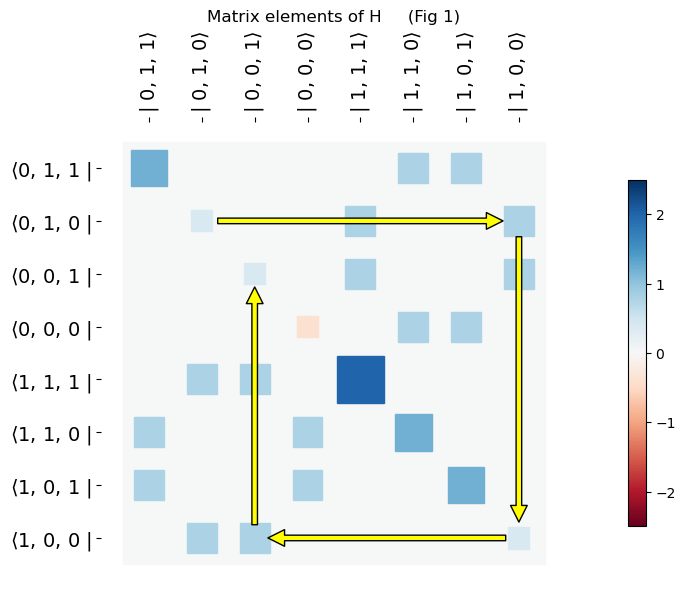

In [200]:
f, ax = hinton(H, xlabels=ket_labels, ylabels=bra_labels)
ax.tick_params(axis='x',labelrotation=90)
ax.set_title("Matrix elements of H     (Fig 1)");

ax.annotate('', xy=(7.5, 6.5), xytext=(1.5, 6.5), arrowprops=dict(facecolor='yellow', shrink=0.05))
ax.annotate('', xy=(7.5, 0.5), xytext=(7.5, 6.5), arrowprops=dict(facecolor='yellow', shrink=0.05))
ax.annotate('', xy=(2.5, 0.5), xytext=(7.5, 0.5), arrowprops=dict(facecolor='yellow', shrink=0.05))
ax.annotate('', xy=(2.5, 5.5), xytext=(2.5, 0.5), arrowprops=dict(facecolor='yellow', shrink=0.05));

Each square in Fig. 1 is often called a matrix element. Matrix elements are described by the states they are associated with as seen on the horizontal and vertical axes. Diagonal matrix elements give us information about the energy of a particular state. Off diagonal matrix elements tell us how different states are coupled together. 

If two states have zero off diagonal matrix element, then they are not coupled together directly. States can however be indirectly coupled as seen by the yellow arrows in Fig. 1 that describes one path of a single excitation to transfer from system A to system B.
> Aside: We introduced these paths and described how to construct them in [tutorial 4](https://nbviewer.org/github/project-ida/two-state-quantum-systems/blob/master/04-spin-boson-model.ipynb) and [tutorial 5](https://nbviewer.org/github/project-ida/two-state-quantum-systems/blob/master/05-excitation-transfer.ipynb).

We can write the excitation transfer pathway as $|0, 1, 0  \rangle \rightarrow |1, 0, 0  \rangle \rightarrow |0, 0, 1  \rangle$ where we describe the state in between the initial and final state as the "intermediate state".

What's really interesting in quantum mechanics is that these intermediate states don't necessary have to obey our normal sense of energy conservation. If e.g. $\Delta E = \hbar\omega$, then the pathway would be fully energy conserving and would represent the processes of boson emission from system A and then absorption into system B. If however, we had e.g. $\Delta E \gg \hbar\omega$ then this would not be the case and we'd have the non-radiative excitation transfer that's been a large focus of this tutorial series.

The energy non-conserving aspect of intermediate states is most strikingly demonstrated by looking at the other pathway that's suggested in the Hinton diagram.

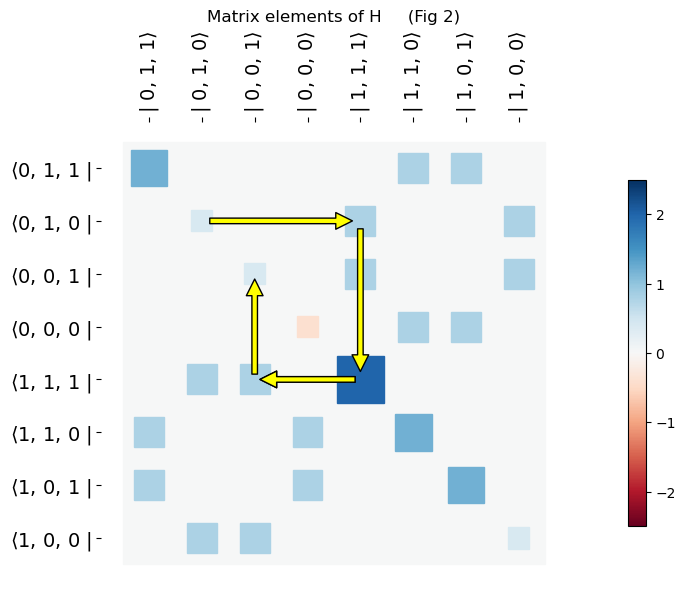

In [199]:
f, ax = hinton(H, xlabels=ket_labels, ylabels=bra_labels)
ax.tick_params(axis='x',labelrotation=90)
ax.set_title("Matrix elements of H     (Fig 2)");
ax.annotate('', xy=(4.5, 6.5), xytext=(1.5, 6.5), arrowprops=dict(facecolor='yellow', shrink=0.05))
ax.annotate('', xy=(4.5, 3.5), xytext=(4.5, 6.5), arrowprops=dict(facecolor='yellow', shrink=0.05))
ax.annotate('', xy=(2.5, 3.5), xytext=(4.5, 3.5), arrowprops=dict(facecolor='yellow', shrink=0.05))
ax.annotate('', xy=(2.5, 3.5), xytext=(4.5, 3.5), arrowprops=dict(facecolor='yellow', shrink=0.05))
ax.annotate('', xy=(2.5, 5.5), xytext=(2.5, 3.5), arrowprops=dict(facecolor='yellow', shrink=0.05));


The excitation transfer pathway shown in Fig. 2 can be witten as $|0, 1, 0  \rangle \rightarrow |1,1, 1  \rangle \rightarrow |0, 0, 1  \rangle$ and is always energy non-conserving regardless of the system parameters we choose.

Sometimes you'll hear these non-conserving intermediate states describes as "virtual states", sometimes as "off-resonant states". The off-resonant language refers to how each states has a characteristic energy and hence frequency.

For non radiative excitation transfer, the TLS transition energy is not matched to the boson energy. In this case, both intermediate states are off-resonant and, as a consequence, their occupation probability is negligibly small (for small coupling). We've seen this in our first encounter with excitation transfer, but let's confirm it again below by simulation.

In [201]:
DeltaE = 10.5 # Mismatch between boson energy and the TLS energy to make sure we avoid emission
omega = 1
U = 0.01 

In [202]:
# Field in vacuum state (0) with 1 excitation in A (1) and 0 excitations in B (0)
psi0_ind = nmm_list.index((0,1,0))  
psi0 = basis(len(nmm_list), psi0_ind)

In [203]:
# THIS WILL USE A LOT OF RAM. COLAB MIGHT CRASH DEPENDING ON RESOURCES AVAILABLE ON YOUR ACCOUNT
# We're using a very high resolution in time because we're going to be interested in 
# looking at the wavefunction as well as the probability 
# and the wavefunction has high frequency oscillations that we want to resolve.
times = np.linspace(0,  2000000, 20000000)

In [204]:
H = DeltaE*two_state_A + DeltaE*two_state_B + omega*bosons + U*interaction_A + U*interaction_B

In [205]:
# Just like last time, we are using custom simulate function because it's going to be quicker
# in this case because of the long simulation times. Note that this still takes about 30s to run
# because of the high time resolution we've chosen for this simulation
P, psi, evals, ekets = simulate(H, psi0, times)

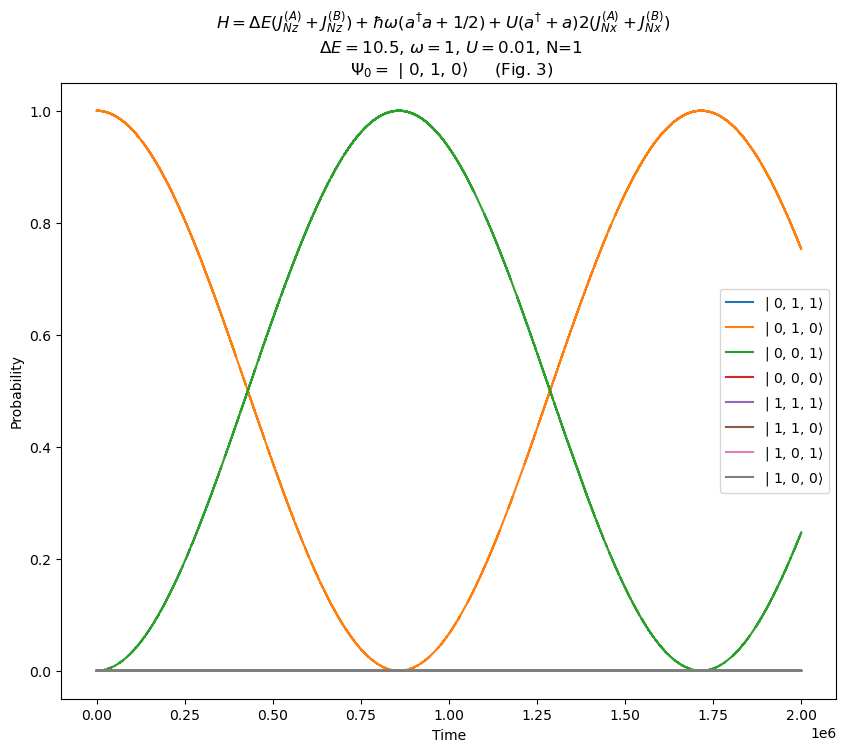

In [206]:
plot_sim(times, P, labels=ket_labels)
plt.title(f'{H_latex_AB}  \n $\Delta E={DeltaE}$, $\omega={omega}$, $U={U}$, N={1} \n $\Psi_0 =$ {ket_labels[psi0_ind]}     (Fig. 3)');

As expected, Fig. 3 shows that there is no meaningful probability in the off-resonant states as one would expect.

Although there is no meaningful occupation probability in the off-resonant states, they have a profound impact on the excitation transfer dynamics that we've so far ignored. To understand this impact, we need to take a look at the wavefunctions for the intermediate states $|1, 0, 0   \rangle$ and $|1, 1, 1  \rangle$.

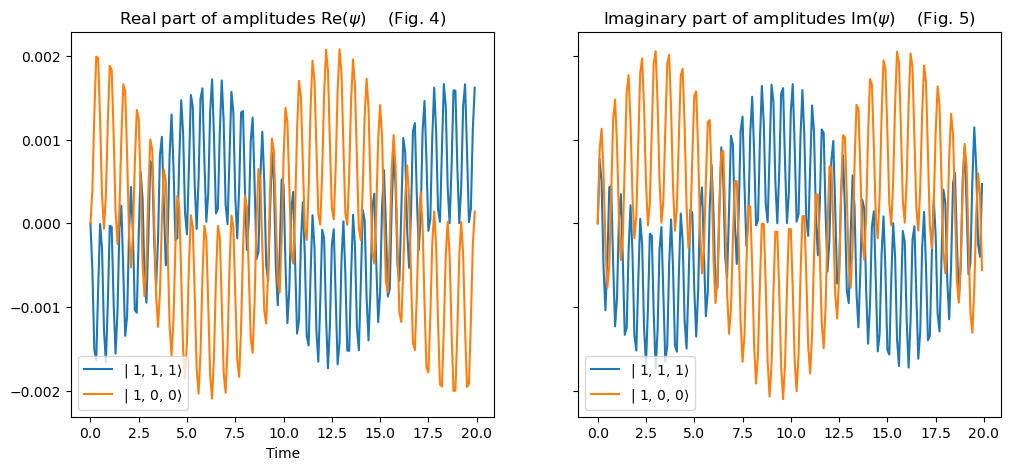

In [207]:
fig, (ax_real, ax_imag) = plt.subplots(1,2, sharey=True, figsize=(12, 5))

ax_real.plot(times[0:200],psi[4,0:200], label=ket_labels[4])
ax_real.plot(times[0:200],psi[7,0:200], label=ket_labels[7])
ax_real.set_title('Real part of amplitudes Re($\psi$)    (Fig. 4)')
ax_real.set_xlabel('Time')

ax_imag.plot(times[0:200],1j*psi[4,0:200], label=ket_labels[4])
ax_imag.plot(times[0:200],1j*psi[7,0:200], label=ket_labels[7])
ax_imag.set_title('Imaginary part of amplitudes Im($\psi$)    (Fig. 5)')


ax_real.legend()
ax_imag.legend();

Notice how in Figs. 4 and 5 the intermediate states $|1, 0, 0  \rangle$ and $|1, 1, 1  \rangle$ move out of phase with each other in the sense that when one is at its maximum positive the other is at its maximum negative - they appear to almost cancel each other out. If these were e.g. two water waves we'd call this destructive interference and the result would be a very tiny wave. Is this how it works in the quantum world and if so how does a tiny wave in $|1, 0, 0  \rangle + |1, 1, 1  \rangle$ relate to the speed of excitation transfer?

Before we get our analytical toolbox out, let's take a helpful detour back into classical physics.

## 9.3 - Classical analogue

It can be quite difficult to build an intuition for the kind of quantum effects that we've seen throughout this series. It's therefore helpful to try as much as possible to map our quantum problems to equivalent classical ones.

At the start of this tutorial series ([tutorial 1](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/01-an-isolated-two-state-system.ipynb)), we made a connection to coupled pendulums to create intuition for Rabi oscillations. It turns out (quite fortunately for us) that many of our quantum problems can be mapped rigorously to such a familiar classical system in the small angle approximation. Each state is represented by a pendulum whose frequency is proportional to the energy of that state as given to us by the Hamiltonian without the interaction terms:

$$H_0 =  \Delta E_A J_{N_Az}^{(A)} + \Delta E_B J_{N_Bz}^{(B)} + \hbar\omega\left(a^{\dagger}a +\frac{1}{2}\right)$$

In other words, the frequencies are proportional to the diagonal matrix elements of $H$. The coupling between the pendulums is modelled via a connecting spring, whose stiffness is proportional to the off diagonal matrix elements of H.
> Aside: We'll not prove all this here because it will take us to too far off track. If you're interested to go down that delightful rabbit hole then check out e.g. [Coherent quantum states from classical oscillator amplitudes](https://journals.aps.org/pra/abstract/10.1103/PhysRevA.85.052111) by Briggs et.al.

The classical equivalent of our excitation transfer problem is a 4 pendulum system that we can see in action in Fig. 6 below.

**Fig. 6** (If no video displays then [view notebook in nbviewer](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/09-destructive-interference.ipynb)) or run `Video("img/pendulum-destructive.mp4", embed=True)`

<video src="img/pendulum-destructive.mp4" width="600" controls>
  Your browser does not support the video tag.
</video>

The mapping between the classical and quantum worlds looks like this:
- $|0,+,- \rangle $ - Blue
- $|0,-,+ \rangle $ - Orange
- $|1,+,+ \rangle$ - Red
- $|1,-,- \rangle$ - Green

The blue and orange pendulums have the same length (and hence frequency) because the equivalent quantum states ($|0,+,- \rangle $ & $|0,-,+ \rangle $) have the same energy. The red pendulum is shorter and hence has a higher frequency because its equivalent quantum state ($|1,+,+ \rangle$) has both TLS in the higher energy ($+$) state. Similarly, the green pendulum is shorter and hence has a lower frequency because its equivalent quantum state ($|1,-,- \rangle$) has both TLS in the lower energy ($-$) state. 

Fig. 6 shows how the blue and orange pendulums are not directly coupled, but instead indirectly coupled through the red and green pendulums as is the case for our equivalent quantum problem. Despite the coupling, we see that barely any excitation transfers from the blue to the orange because the red and green are almost always completely out of phase.

> Aside: We've exaggerated the displacement of the pendulums to make the motion visible. We also positioned the ends of the green and red pendulums at different heights to make things easier to see. The actual simulation has the ends of the pendulums at the same height. See appendix for more details.

In general, 4 pendulums coupled in this way will not exhibit such a high level of destructive interference. It only occurs in this case because of the very specific relationship between the frequencies that comes from the energy of the equivalent quantum states, namely:

$$\omega^2_{\text{blue}} = \omega^2_{\text{orange}} = \frac{1}{2}(\omega^2_{\text{red}}+\omega^2_{\text{green}})$$

where in the pendulum world we work with the square of the frequency $\omega^2$ instead of energy $E$ as we do in the quantum world.

What we're starting to understand from this little classical detour is that indirect coupling between states does not guarantee a transfer between those states. Yes it matters what coupling constants we have, but the relationship between the energies of the states also seems to be just as important. Can we make this idea more concrete... yes we can! Let's flex our analytical muscles and see if we can derive an effective coupling constant directly between $|0,+,- \rangle $ and $|0,-,+ \rangle $, removing the intermediate middle men 💪.

## 9.4 - Extracting destructive interference analytically

As we saw in previous tutorials, studying the energy levels of a system is a good way to get insight into how it behaves. For example, we've understood Rabi oscillations as resulting from the frequency "beating" of two closely spaced energy levels that would otherwise be degenerate (i.e. the same energy) in the absence of the coupling between the TLS and the field.

We've previously looked at energy levels numerically using QuTiP - now we're going to work analytically. Let's first remind ourselves of where all this energy level stuff comes from.

The energy levels are found by solving the the time independent Schrödinger equation:

$$H\Psi = E\Psi$$

which involves finding states $\Psi$ that don't change under the action of the Hamiltonian $H$ other than being multiplied by a constant $E$ that we associate with the state's energy. The states $\Psi$ are often referred to as "stationary states" and the energies $E$ as "energy levels". In mathematical language we refer to $E$ and $\Psi$ as eigenvalues and eigenvectors (or eigenstates) of the Hamiltonian operator. 





For our system, $\Psi$ has 8 components that must be solved for simultaneously.

$$
\Psi = \begin{pmatrix}
 \Psi_{|0,1,1\rangle}   \\
 \Psi_{|0,1,0\rangle}   \\
 \Psi_{|0,0,1\rangle}   \\
 \Psi_{|0,0,0\rangle}   \\
 \Psi_{|1,1,1\rangle}   \\
 \Psi_{|1,1,0\rangle}   \\
  \Psi_{|1,0,1\rangle}   \\
  \Psi_{|1,0,0\rangle}   \\
 \end{pmatrix}
$$

However, for our excitation transfer problem we only need to keep 4 of these components as can be seen by performing the matrix multiplication $H\Psi$ and keeping rows 2, 3, 5 and 8 associated with states $|0,1,0\rangle$, $|0,0,1\rangle$, $|1,1,1\rangle$, $|1,0,0\rangle$. If you inspect the Hamiltonian, you'll notice that these 4 states couple to each other and no others.

In [181]:
H

Quantum object: dims = [[8], [8]], shape = (8, 8), type = oper, isherm = True
Qobj data =
[[ 1.1e+01  0.0e+00  0.0e+00  0.0e+00  0.0e+00  1.0e-02  1.0e-02  0.0e+00]
 [ 0.0e+00  5.0e-01  0.0e+00  0.0e+00  1.0e-02  0.0e+00  0.0e+00  1.0e-02]
 [ 0.0e+00  0.0e+00  5.0e-01  0.0e+00  1.0e-02  0.0e+00  0.0e+00  1.0e-02]
 [ 0.0e+00  0.0e+00  0.0e+00 -1.0e+01  0.0e+00  1.0e-02  1.0e-02  0.0e+00]
 [ 0.0e+00  1.0e-02  1.0e-02  0.0e+00  1.2e+01  0.0e+00  0.0e+00  0.0e+00]
 [ 1.0e-02  0.0e+00  0.0e+00  1.0e-02  0.0e+00  1.5e+00  0.0e+00  0.0e+00]
 [ 1.0e-02  0.0e+00  0.0e+00  1.0e-02  0.0e+00  0.0e+00  1.5e+00  0.0e+00]
 [ 0.0e+00  1.0e-02  1.0e-02  0.0e+00  0.0e+00  0.0e+00  0.0e+00 -9.0e+00]]

The Schrödinger equation can therefore be reduced to:

$$ E\Psi_{|0,1,0\rangle}= 0.5\Psi_{|0,1,0\rangle} + 0.01\Psi_{|1,1,1\rangle} + 0.01\Psi_{|1,0,0\rangle} \qquad\qquad (1)$$

$$ E \Psi_{|1,1,1\rangle}  = 12\Psi_{|1,1,1\rangle} + 0.01\Psi_{|0,1,0\rangle} + 0.01\Psi_{|0,0,1\rangle} \qquad\qquad (2)$$

$$ E\Psi_{|1,0,0\rangle} = -9\Psi_{|1,0,0\rangle} + 0.01\Psi_{|0,1,0\rangle} + 0.01\Psi_{|0,0,1\rangle} \qquad\qquad (3)$$

$$ E\Psi_{|0,0,1\rangle} = 0.5\Psi_{|0,0,1\rangle} + 0.01\Psi_{|1,1,1\rangle} + 0.01\Psi_{|1,0,0\rangle} \qquad\qquad (4)$$

will all the other components of $\Psi$ equal to zero.

You see that +12 and that -9 in Eqs. 2 and 3 - that's what's going to give us the cancellation that we expect from destructive interference. But, I'm getting ahead of myself...

We're now going to do something a little sneaky with Eqs. 2 and 3 😈. We're going to pretend that we already know what the value of $E$ is even though that's something we want to solve for. This allows us to solve for $\Psi_{|1,1,1\rangle}$ and $\Psi_{|1,0,0\rangle}$:

$$ \Psi_{|1,1,1\rangle}  =  \frac{0.01\Psi_{|0,1,0\rangle} + 0.01\Psi_{|0,0,1\rangle}}{E-12} \qquad\qquad (5)$$

$$ \Psi_{|1,0,0\rangle}  =  \frac{0.01\Psi_{|0,1,0\rangle} + 0.01\Psi_{|0,0,1\rangle}}{E+9} \qquad\qquad (6)$$

If we now substitute Eqs. 5 and 6 into Eqs. 1 and 4, then we remove the "middle men" and turn the indirect coupling between states $|0,1,0\rangle$ and $|0,0,1\rangle$ into something that looks more like an effective direct coupling:

$$ E\Psi_{|0,1,0\rangle}= \left(0.5 + \frac{0.01^2}{E-12} +  \frac{0.01^2}{E+9}\right)\Psi_{|0,1,0\rangle} + 0.01^2\left(\frac{1}{E-12} +  \frac{1}{E+9}\right)\Psi_{|0,0,1\rangle} \qquad\qquad (7)$$

$$ E\Psi_{|0,0,1\rangle}= \left(0.5 + \frac{0.01^2}{E-12} +  \frac{0.01^2}{E+9}\right)\Psi_{|0,0,1\rangle} + 0.01^2\left(\frac{1}{E-12} +  \frac{1}{E+9}\right)\Psi_{|0,0,1\rangle} \qquad\qquad (8)$$

By looking at the terms $E-12$ and $E+9$ in the last bracket of Eqs. 7 and 8, we can now start to see how the combined effect of the intermediate states can result in destructive interference. One of our intermediate states ($|1,1,1\rangle$) has high energy (12) and the other state ($|1,0,0\rangle$) has low energy (-9). If the energy of the system $E$ lies in between these two, then we'll get cancellation of the contributions. This would be like the pendulum scenario from earlier.

But is this what happens? We don't know what the energy $E$ is, so we're stuck right?... Wrong!

The smallness in the coupling constant $U=0.01$ invites us to solve Eqs. 7 and 8 iteratively. This means:
1. Pretend that the small terms with $0.01^2$ in front of them don't exist and solve for $E$ - call it $E_0$
2. Bring back the small terms with $0.01^2$ and substitute $E=E_0$ into those terms
3. Solve for $E$ to get an improved estimate beyond $E_0$

This procedure is a variant of what's more generally known as perturbation theory and loosely we can think of it as a way of turning a hard problem into an infinite series of simpler ones. The hope with perturbation theory is that we don't have to solve too many of the simpler problems to extract some useful insight about the hard problem. In our case, we're not even going to need to do step 3 to extract some insight - bonus 🤩.

Step 1.

If no coupling existed then we'd have

$$ E_0\Psi_{|0,1,0\rangle}= 0.5\Psi_{|0,1,0\rangle}  \qquad\qquad (9)$$

$$ E_0\Psi_{|0,0,1\rangle}= 0.5 \Psi_{|0,0,1\rangle} \qquad\qquad (10)$$

from which we can see that $E_0=0.5$. In this case $E_0$ is the energy when one TLS is in $+$ and the other is in $-$ and no bosons are present, in other words it's the energy of the initial and final states $|0,1,0\rangle$ and $|0,0,1\rangle$. 

The energy $E_0$ is indeed in between the energies of the intermediate states, so that we're going to get cancellation. Let's continue.

Step 2.

$$ E\Psi_{|0,1,0\rangle}= \left(0.5 + \frac{0.01^2}{-11.5} +  \frac{0.01^2}{9.5}\right)\Psi_{|0,1,0\rangle} + 0.01^2\left(\frac{1}{-11.5} +  \frac{1}{9.5}\right)\Psi_{|0,0,1\rangle} \qquad\qquad (11)$$

$$ E\Psi_{|0,0,1\rangle}= \left(0.5 + \frac{0.01^2}{-11.5} +  \frac{0.01^2}{9.5}\right)\Psi_{|0,0,1\rangle} + 0.01^2\left(\frac{1}{-11.5} +  \frac{1}{9.5}\right)\Psi_{|0,1,0\rangle} \qquad\qquad (12)$$

What's quite wonderful about Eqs. 11 and 12 is that they look a lot like the equations for a single isolated TLS that we explored way back in [tutorial 1](https://nbviewer.org/github/project-ida/two-state-quantum-systems/blob/master/01-an-isolated-two-state-system.ipynb). Specifically, in the language of tutorial 1, the RHS of Eqs. 11 and 12 could be represented by an effective Hamiltonian

$$
H_{\text{eff}} = \begin{bmatrix}
 E_{\text{eff}}  &  -A_{\text{eff}}  \\
 -A_{\text{eff}}  &  E_{\text{eff}}  \\
\end{bmatrix}
$$

where
$$E_{\text{eff}} = \left(0.5 + \frac{0.01^2}{-11.5} +  \frac{0.01^2}{9.5}\right)$$


$$A_{\text{eff}} = -0.01^2\left(\frac{1}{-11.5} +  \frac{1}{9.5}\right)$$


$$
\Psi_{|0,1,0\rangle} = \begin{bmatrix}
 1   \\
 0   \\
 \end{bmatrix}, 
\Psi_{|0,0,1\rangle} = \begin{bmatrix}
 0   \\
 1   \\
\end{bmatrix}
$$


Viewed in this way, the excitation transfer between $|0,1,0\rangle$ and $|0,0,1\rangle$ is just the familiar Rabi oscillations with a frequency $\Omega = 2|A_{\text{eff}}|$. We can therefore see that the excitation transfer time isn't just determined by the coupling constant $U=0.01$ but is heavily influenced by the destructive interference between the intermediate states $\left(\frac{1}{-11.5} +  \frac{1}{9.5}\right)$.

In general, we can write the Rabi frequency associated with excitation transfer as:

$$\Omega = 2U^2\left( \frac{1}{- \Delta E - \hbar\omega} + \frac{1}{\Delta E - \hbar\omega} \right) = \frac{4U^2\hbar\omega}{(\Delta E)^2 -(\hbar\omega)^2 }  \qquad\qquad (13)$$

where we can see that the larger $\Delta E/\hbar\omega$ gets, the closer to complete destructive interference we'll get and hence no excitation transfer at all ($\Omega \rightarrow 0$). This supports what we found in [tutorial 6](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/06-excitation-transfer-revisited.ipynb), namely that the excitation transfer time got longer as $\Delta E$ was increased. Eq. 13 even gives us the precise quadratic scaling with $\Delta E / U$ that we previously found numerically:

$$\Omega = \frac{4U^2\hbar\omega_0}{(\hbar\omega)^2 - (\Delta E)^2} \rightarrow 4\hbar\omega\left(\frac{U}{\Delta E}\right)^2  \qquad\qquad (14)$$

We've now got a solid foundation of this destructive interference business. We've explore numerical, analytical and classical aspects of this phenomenon. The question now is, what can we do about it?

## 9.5 - Breaking destructive interference

We've seen that destructive interference comes about because some intermediate states have energies above the initial/final state and some have energies below. It can be helpful to visualise this idea by representing the pathway of moving from one state to another horizontally left to right and the energy of the various states involved in the pathway vertically. In our excitation transfer case, this looks like the following:

**Fig. 7**

<img src="img/diamond.png"  width="800"/>

Anything in the top part of the diamond in Fig. 7 destructively interferes with anything in the bottom part of the diamond. In our case, we've only got two intermediate states, but things can get a lot more complicated in general (e.g. Fig. 1 of Hagelstein's [Energy Exchange In The Lossy Spin-Boson Model](https://web.archive.org/web/20210124072252/https://www.rle.mit.edu/hagelstein/pdfs/hagelstein2011a.pdf) ).


Destructive interference slows down processes like excitation transfer. In order to speed things up, we can attempt to remove this interference. But how can we do that?

Conceptually, the best we can possibly hope for is to somehow remove either the upper or lower part of the diamond, e.g.

**Fig. 8**

<img src="img/diamond-half.png"  width="800"/>

Fig. 8 corresponds to a modification of Eq. 13 according to:

$$\Omega = 2U^2\left( \frac{1}{- \Delta E - \hbar\omega}  \right) \rightarrow -\frac{2U^2}{\Delta E} \qquad\qquad (14)$$

Eq. 14 would correspond to an increase in excitation transfer rate by a factor of $\Delta E/\hbar\omega$ which can be significant.

This is all conceptual though, we can't just get rid of pathways by simply willing it 🧙‍♂️. There needs to be some genuine physics that provides a asymmetry between the upper and lower pathways.  

We can look to the classical world for inspiration. In the world of pendulums, there is never a truly perfect swing - there's always some energy lost to due friction of all kinds. If we add a friction force only to the green pendulum from Fig. 6 then we'll create an asymmetry between the intermediate pendulums. If we make that friction force really large then we might hope to produce the classical equivalent of Fig. 8. Let's see.

**Fig. 9** (If no video displays then [view notebook in nbviewer](https://nbviewer.jupyter.org/github/project-ida/two-state-quantum-systems/blob/master/09-destructive-interference.ipynb)) or run `Video("img/pendulum-remove-destructive.mp4.mp4", embed=True)`

<video src="img/pendulum-remove-destructive.mp4" width="600" controls>
  Your browser does not support the video tag.
</video>



Fig. 9 shows us that over the same timescale as Fig. 6 we achieve excitation transfer from the blue to the orange pendulums - we've broken the destructive interference 🙌.

What's really interesting about this large friction case is that we might have expected the large friction to just suck all the energy out of the system really quickly and yet that doesn't happen. The reason is the following:
- the energy dissipation rate is proportional to the friction force and also the speed of the pendulum
- the large friction force means the green pendulum never gets moving so it has zero speed
- speed of zero means dissipation rate is zero

This large friction makes the green pendulum behave like an immovable object and so in that sense it almost ceases to exist from the perspective of the other pendulums - that part of the diamond has effectively gone.

The big question is... can we do something like this in the quantum world?

## Next up...

What does friction/damping/dissipation even mean for a quantum system? It means venturing into "open quantum systems" where the big wide world is allowed to "talk" to our TLS 😱.

Although open systems require new ways of thinking about quantum states, the simulation side of things is once again handled beautifully by QuTiP 😅 - is there anything this library can't do?!

See you next time 👋 .

---
## Appendix - Coupled pendulums


We use the small angle approximation and assume that the vertical position of each pendulum is the same when they are in equilibrium. The spring coupling is described by constant $k$ and is proportional to the angular differences in the coupled pendulums. The friction for the green pendulum is described by constant $b$ and is proportional to its angular speed. 

\begin{align}
\ddot{\theta}_B &= - \omega_0^2 \theta_B + k \left( 2 \theta_B - \theta_R \frac{\omega_0^2}{\omega_R^2} - \theta_G \frac{\omega_0^2}{\omega_G^2} \right) \\
\ddot{\theta}_O &= - \omega_0^2 \theta_O + k \left( 2 \theta_O - \theta_R \frac{\omega_0^2}{\omega_R^2} - \theta_G \frac{\omega_0^2}{\omega_G^2} \right) \\
\ddot{\theta}_R &= - \omega_R^2 \theta_R + k \left( 2 \theta_R - \theta_O \frac{\omega_R^2}{\omega_0^2} - \theta_B \frac{\omega_R^2}{\omega_0^2} \right) \\
\ddot{\theta}_G &= - \omega_G^2 \theta_G + k \left( 2 \theta_G - \theta_O \frac{\omega_G^2}{\omega_0^2} - \theta_B \frac{\omega_G^2}{\omega_0^2} \right) - b\dot{\theta}_G
\end{align}


First we solve these equations numerically - we use scipy's [`solve_ivp`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.integrate.solve_ivp.html) for the heavy lifting.

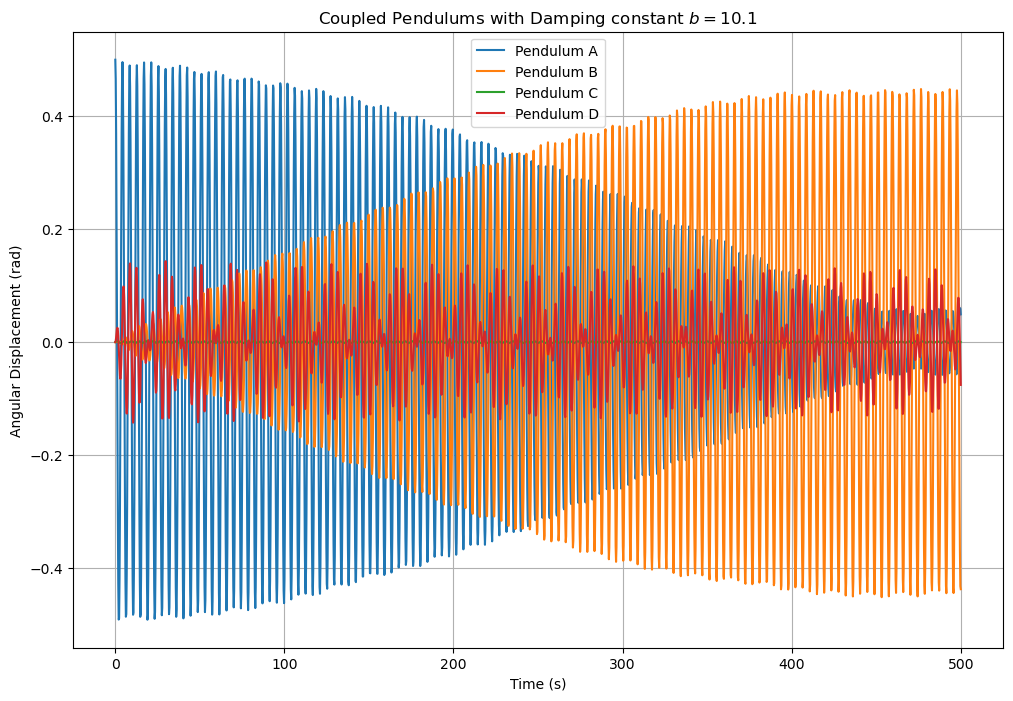

In [212]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Natural frequencies of the pendulums that maps to the excitation transfer problem
w_A, w_B = np.sqrt(2), np.sqrt(2)
w_C = 1
w_D = np.sqrt(3)

k = 0.1  # small coupling constant
b = 10.1  # large damping coefficient for pendulum C

# Define the system of ODEs
def equations(t, y):
    theta_A, omega_A, theta_B, omega_B, theta_C, omega_C, theta_D, omega_D = y
    
    dtheta_A = omega_A
    domega_A = -(w_A**2 + 2*k) * theta_A + k * w_A**2*(theta_C/w_C**2 + theta_D/w_D**2)
    
    dtheta_B = omega_B
    domega_B = -(w_B**2 + 2*k) * theta_B + k * w_B**2*(theta_C/w_C**2 + theta_D/w_D**2)
    
    dtheta_C = omega_C
    domega_C = -b * omega_C - (w_C**2 + 2*k) * theta_C + k * w_C**2*(theta_A/w_A**2 + theta_B/w_B**2)
    
    dtheta_D = omega_D
    domega_D = -(w_D**2 + 2*k) * theta_D + k * w_D**2*(theta_A/w_A**2 + theta_B/w_B**2)

    return [dtheta_A, domega_A, dtheta_B, domega_B, dtheta_C, domega_C, dtheta_D, domega_D]

# Initial conditions
theta_A0 = 0.5  # initial amplitude for pendulum A
omega_A0 = 0.0  # initial angular velocity for pendulum A
theta_B0 = 0.0  # initial amplitude for pendulum B
omega_B0 = 0.0  # initial angular velocity for pendulum B
theta_C0 = 0.0  # initial amplitude for pendulum C
omega_C0 = 0.0  # initial angular velocity for pendulum C
theta_D0 = 0.0  # initial amplitude for pendulum D
omega_D0 = 0.0  # initial angular velocity for pendulum D

# Bundle initial conditions into a single list
initial_conditions = [theta_A0, omega_A0, theta_B0, omega_B0, theta_C0, omega_C0, theta_D0, omega_D0]

# Time span for the simulation
t_span = (0, 500)  # start and end times
t_eval = np.linspace(*t_span, 2000)  # time points where the solution is computed

# Solve the system of ODEs
solution = solve_ivp(equations, t_span, initial_conditions, t_eval=t_eval, method='RK45')

# Extract the solutions for each pendulum
theta_A_sol = solution.y[0]
theta_B_sol = solution.y[2]
theta_C_sol = solution.y[4]
theta_D_sol = solution.y[6]


# Plot the results
plt.figure(figsize=(12, 8))
plt.plot(t_eval, theta_A_sol, label='Pendulum A')
plt.plot(t_eval, theta_B_sol, label='Pendulum B')
plt.plot(t_eval, theta_C_sol, label='Pendulum C')
plt.plot(t_eval, theta_D_sol, label='Pendulum D')
plt.xlabel('Time (s)')
plt.ylabel('Angular Displacement (rad)')
plt.title(f'Coupled Pendulums with Damping constant $b=${b}')
plt.legend()
plt.grid(True)
plt.show()

To make the fancy swinging pendulums animation we rely on matplotlib's [`FuncAnimation`](https://matplotlib.org/stable/api/_as_gen/matplotlib.animation.FuncAnimation.html). Note that saving the animation to a file and then displaying the file afterwards is the only way I got it to work.

In [ ]:
from IPython.display import HTML
from matplotlib.animation import FuncAnimation

# Convert natural frequencies of pendulums into pendulum lengths
l_ab = 4.9
l_c = 9.8
l_d = 3.27

# Convert angular displacements to Cartesian coordinates for animation
offset_A = -5  # horizontal offset for pendulum A
offset_B = 5   # horizontal offset for pendulum B
offset_C_vertical = 0  # vertical offset for pendulum C
offset_D_vertical = 0  # vertical offset for pendulum D

x_A = offset_A + l_ab * np.sin(theta_A_sol)
y_A = -l_ab * np.cos(theta_A_sol)
x_B = offset_B + l_ab * np.sin(theta_B_sol)
y_B = -l_ab * np.cos(theta_B_sol)
x_C = l_c * np.sin(theta_C_sol)
y_C = offset_C_vertical - l_c * np.cos(theta_C_sol)
x_D = l_d * np.sin(theta_D_sol)
y_D = offset_D_vertical - l_d * np.cos(theta_D_sol)

# Set up the figure and axis
fig, ax = plt.subplots()
ax.set_xlim(-10, 10)
ax.set_ylim(-12, 1)
ax.set_aspect('equal')

# Create lines for each pendulum
line_A, = ax.plot([], [], 'o-', lw=2, label='Pendulum A')
line_B, = ax.plot([], [], 'o-', lw=2, label='Pendulum B')
line_C, = ax.plot([], [], 'o-', lw=2, label='Pendulum C')
line_D, = ax.plot([], [], 'o-', lw=2, label='Pendulum D')
line_AC, = ax.plot([], [], color='grey', lw=1)  # Line connecting A to C
line_AD, = ax.plot([], [], color='grey', lw=1)  # Line connecting A to D
line_CB, = ax.plot([], [], color='grey', lw=1)  # Line connecting C to B
line_DB, = ax.plot([], [], color='grey', lw=1)  # Line connecting D to B

# Initialize the animation
def init():
    line_A.set_data([], [])
    line_B.set_data([], [])
    line_C.set_data([], [])
    line_D.set_data([], [])
    line_AC.set_data([], [])
    line_AD.set_data([], [])
    line_CB.set_data([], [])
    line_DB.set_data([], [])
    return line_A, line_B, line_C, line_D, line_AC, line_AD, line_CB, line_DB

# Update function for the animation
def update(frame):
    line_A.set_data([offset_A, x_A[frame]], [0, y_A[frame]])
    line_B.set_data([offset_B, x_B[frame]], [0, y_B[frame]])
    line_C.set_data([0, x_C[frame]], [offset_C_vertical, y_C[frame]])
    line_D.set_data([0, x_D[frame]], [offset_D_vertical, y_D[frame]])
    line_AC.set_data([x_A[frame], x_C[frame]], [y_A[frame], y_C[frame]])
    line_AD.set_data([x_A[frame], x_D[frame]], [y_A[frame], y_D[frame]])
    line_CB.set_data([x_C[frame], x_B[frame]], [y_C[frame], y_B[frame]])
    line_DB.set_data([x_D[frame], x_B[frame]], [y_D[frame], y_B[frame]])
    return line_A, line_B, line_C, line_D, line_AC, line_AD, line_CB, line_DB

# Create the animation
ani = FuncAnimation(fig, update, frames=len(t_eval), init_func=init, blit=False, interval=40)

# Display the animation as HTML - THIS DIDN'T WORK FOR ME
# HTML(ani.to_jshtml())

# Save the animation as a file
ani.save('ani.mp4', writer='ffmpeg', fps=30)

In [ ]:
from IPython.display import Video
Video("ani.mp4") # Google Colab users might need to add embed=True to the Video function